## Using pretrained model to do cat vs dog classification

In [1]:
from tensorflow.keras.applications import VGG16

In [2]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Feature extraction with out data augmentation

In [8]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
base_dir = '/Users/Jingxiu Hu/Desktop/DeepLearningWithPython/dogs_vs_cats/cats_and_dogs_small'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

## extract features using the pretrained convolutional base

In [10]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count,4,4,512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory, target_size=(150,150), batch_size=batch_size,class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size:(i+1) * batch_size] = features_batch
        labels[i * batch_size:(i+1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
               break
    return features, labels

In [11]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

## Defining and training the densely connected classifier

In [14]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [15]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizers=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30, batch_size=20, 
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 839us/sample - loss: 0.7247 - acc: 0.7625 - val_loss: 0.4393 - val_acc: 0.7890
Epoch 2/30
2000/2000 [==============================] - 0s 211us/sample - loss: 0.3340 - acc: 0.8605 - val_loss: 0.2620 - val_acc: 0.9000
Epoch 3/30
2000/2000 [==============================] - 0s 209us/sample - loss: 0.2878 - acc: 0.8845 - val_loss: 0.3014 - val_acc: 0.8860
Epoch 4/30
2000/2000 [==============================] - 0s 208us/sample - loss: 0.2532 - acc: 0.8985 - val_loss: 0.2957 - val_acc: 0.8930
Epoch 5/30
2000/2000 [==============================] - 0s 219us/sample - loss: 0.2135 - acc: 0.9155 - val_loss: 0.2854 - val_acc: 0.8960
Epoch 6/30
2000/2000 [==============================] - 0s 213us/sample - loss: 0.1875 - acc: 0.9240 - val_loss: 0.2677 - val_acc: 0.8980
Epoch 7/30
2000/2000 [==============================] - 0s 213us/sample - loss: 0.1758 - acc: 0.9285 - val_loss: 0.3070 - va

## Visualize accuarcy and loss of the model

In [16]:
import matplotlib.pyplot as plt

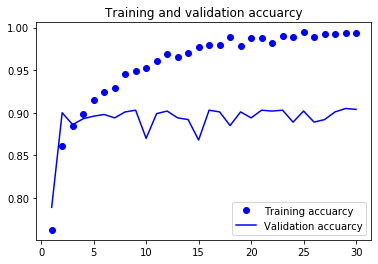

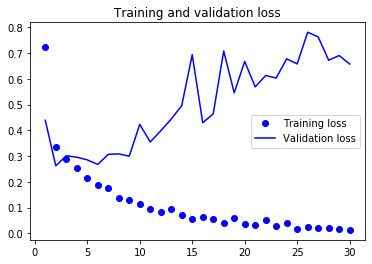

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuarcy')
plt.plot(epochs, val_acc, 'b', label='Validation accuarcy')
plt.title('Training and validation accuarcy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## We see significant overfitting in the plot. Becasue we didn't use data augmentation.

## Feature extraction with data augmentation.

In [19]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


## Freeze layers in conv_base to prevent their weights from being updated during training.

In [21]:
conv_base.trainable = False

## Training the model end to end with a frozen convolutional base

In [22]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150,150), batch_size=20, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150,150), batch_size=20, 
                                                              class_mode='binary')

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30, validation_data=validation_generator,
                              validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 34s 337ms/step - loss: 0.5810 - acc: 0.7135 - val_loss: 0.4397 - val_acc: 0.8250
Epoch 2/30
100/100 [==============================] - 32s 323ms/step - loss: 0.4780 - acc: 0.7870 - val_loss: 0.3676 - val_acc: 0.8550
Epoch 3/30
100/100 [==============================] - 32s 324ms/step - loss: 0.4314 - acc: 0.8045 - val_loss: 0.3277 - val_acc: 0.8620
Epoch 4/30
100/100 [==============================] - 32s 324ms/step - loss: 0.4060 - acc: 0.8145 - val_loss: 0.2980 - val_acc: 0.8810
Epoch 5/30
100/100 [==============================] - 32s 325ms/step - loss: 0.3785 - acc: 0.8330 - val_loss: 0.2935 - val_acc: 0.8750
Epoch 6/30
100/100 [==============================] - 33s 325ms/step - loss: 0.3670 - acc: 0.8370 - val_loss: 0.2803 - val_acc: 0.8840
Epoch 7/30
100/100 [==============================] - 33s 326ms/step - loss: 0.3590 - acc: 0.8465 - val_lo

## We can see we reduced overfitting by using data augmentation.

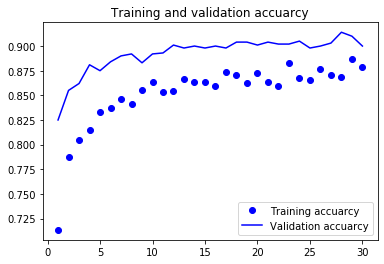

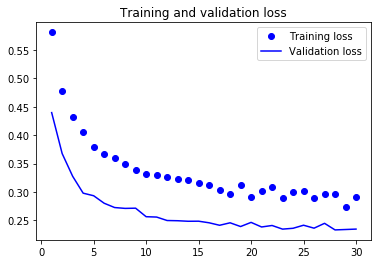

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuarcy')
plt.plot(epochs, val_acc, 'b', label='Validation accuarcy')
plt.title('Training and validation accuarcy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Fine tunning the model.

In [24]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [26]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])

history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100, validation_data=validation_generator, 
                              validation_steps=50)

Epoch 1/100
100/100 [==============================] - 33s 327ms/step - loss: 0.2820 - acc: 0.8850 - val_loss: 0.3032 - val_acc: 0.8820
Epoch 2/100
100/100 [==============================] - 33s 327ms/step - loss: 0.2615 - acc: 0.8935 - val_loss: 0.2104 - val_acc: 0.9200
Epoch 3/100
100/100 [==============================] - 33s 328ms/step - loss: 0.2339 - acc: 0.9040 - val_loss: 0.1981 - val_acc: 0.9260
Epoch 4/100
100/100 [==============================] - 33s 329ms/step - loss: 0.2292 - acc: 0.9020 - val_loss: 0.2057 - val_acc: 0.9220
Epoch 5/100
100/100 [==============================] - 33s 329ms/step - loss: 0.2137 - acc: 0.9150 - val_loss: 0.2034 - val_acc: 0.9160
Epoch 6/100
100/100 [==============================] - 33s 329ms/step - loss: 0.1918 - acc: 0.9235 - val_loss: 0.1959 - val_acc: 0.9200
Epoch 7/100
100/100 [==============================] - 33s 329ms/step - loss: 0.1848 - acc: 0.9210 - val_loss: 0.1889 - val_acc: 0.9310
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 34s 338ms/step - loss: 0.0342 - acc: 0.9855 - val_loss: 0.2258 - val_acc: 0.9410
Epoch 62/100
100/100 [==============================] - 34s 338ms/step - loss: 0.0439 - acc: 0.9835 - val_loss: 0.2175 - val_acc: 0.9400
Epoch 63/100
100/100 [==============================] - 34s 338ms/step - loss: 0.0392 - acc: 0.9850 - val_loss: 0.2177 - val_acc: 0.9380
Epoch 64/100
100/100 [==============================] - 34s 338ms/step - loss: 0.0304 - acc: 0.9895 - val_loss: 0.2100 - val_acc: 0.9400
Epoch 65/100
100/100 [==============================] - 34s 339ms/step - loss: 0.0376 - acc: 0.9880 - val_loss: 0.2257 - val_acc: 0.9450
Epoch 66/100
100/100 [==============================] - 34s 338ms/step - loss: 0.0256 - acc: 0.9930 - val_loss: 0.2626 - val_acc: 0.9390
Epoch 67/100
100/100 [==============================] - 34s 339ms/step - loss: 0.0210 - acc: 0.9935 - val_loss: 0.2305 - val_acc: 0.9420
Epoch 68/100
100/100 [===================

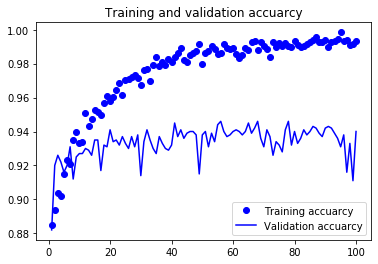

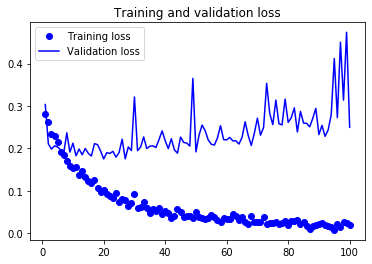

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuarcy')
plt.plot(epochs, val_acc, 'b', label='Validation accuarcy')
plt.title('Training and validation accuarcy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Smooth the validation accuarcy and loss curve

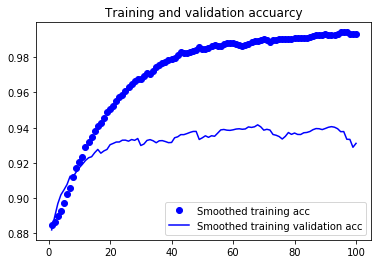

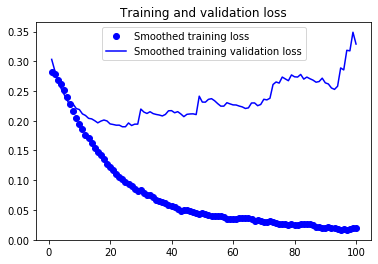

In [29]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed training validation acc')
plt.title('Training and validation accuarcy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed training validation loss')
plt.title('Training and validation loss')
plt.legend()

## Check the accuarcy we get on the test data

In [30]:
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150,150), batch_size=20, class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.936
